In [1]:
import pandas as pd
import os
from magpy.oracles.mixed import MixedDataOracle
from magpy.search.pcskeleton import pc_skeleton, parallel_pc_skeleton
import logging
import networkx as nx
import matplotlib.pyplot as plt

try:
    _SETUP
except NameError:
    os.chdir("..")
    _SETUP = True


logging.basicConfig(level=logging.INFO)

print("running on folder: ", os.getcwd())

df = pd.read_csv("data/SF_Traffic.csv")

/Users/andre/magpy/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


running on folder:  /Users/andre/magpy


/var/folders/5d/bg50v_hd3b90vwxc83124gt00000gn/T/ipykernel_2000/1210815004.py:15: DtypeWarning: Columns (3,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/SF_Traffic.csv")


In [2]:
df = df[
    [
        "accident_year",
        "dph_col_grp_description",
        "party2_move_pre_acc",
        "collision_severity",
        "type_of_collision",
        "weather_1",
        "number_killed",
        "party1_move_pre_acc",
        "road_cond_1",
        "lighting",
        "number_injured",
        "analysis_neighborhood",
        "day_of_week",
    ]
]

# let's encode this as a string so it gets treated as a categorical variable since we don't expect a
df["accident_year"] = df["accident_year"].astype(str)

## Running causal discovery

Let's first define a conditional independence test - this is an object that, as the name suggests, test whether two variables are conditionally independent given a set of conditioning variables.

In this problem we will use the `MixedDataOracle` which implements a conditional independence test based on a Linear Discriminant Analysis (LDA) classifier, as well as a Chi Square contingency test.

The `threshold` parameter controls the significance level of the conditional independence test.


In [17]:
oracle = MixedDataOracle(df.dropna(), threshold=0.01)

In [19]:
# Low p-value -> high association! These are not independent!
oracle._run("number_killed", "number_injured", [])

np.float64(1.1102230246251565e-16)

In [22]:
# P-value is high -> these are likely independent!
oracle._run("number_killed", "number_injured", ["collision_severity"])

np.float64(0.18890806975492502)

`Number killed` and `number injured` are likely independent, since when we control for the `collision severity` the p-value is high.

The causal story is that `collision severity` determines the number of people killed and injured.

You can just get a yes/no answer by asking the oracle directly:


In [23]:
oracle("number_killed", "number_injured", ["collision_severity"])

True

## Running a skeleton search

Now let's try the following: for every pair of variables, we check if they are independent given their neighbors. But instead of randomly checking every possible combination of variables to test, we take a gradual approach, in which we first check pairs without a conditioning set, remove edges, then incrementally increase the size of the conditioning set.

To run the entire search, you can just call:

```python
skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, n_jobs=20, verbose=True
)
```

This will run the entire search in one go. And should take a while to complete (15 mins or so).

Let's do the search in smaller chunks instead:


In [25]:
# We use the max_set_size parameter to control the size of the conditioning set.

skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, max_sepset_size=1, n_jobs=20, verbose=True
)

INFO:root:Processing conditioning set of size: 0
INFO:root:Cond set 0: Processing 91 edges
Processing: 100%|██████████| 91/91 [00:19<00:00,  4.60it/s]
INFO:root:Removed edge accident_year -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge dph_col_grp_description -- road_cond_2 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge collision_severity -- road_cond_1 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge collision_severity -- day_of_week based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge type_of_collision -- road_cond_2 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge weather_1 -- number_killed based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge weather_1 -- road_cond_2 based on the conditioning set: () (cond_set_size: 0)
INFO:root:Removed edge weather_1 -- day_of_week based on the conditioning set: () (cond_set_size

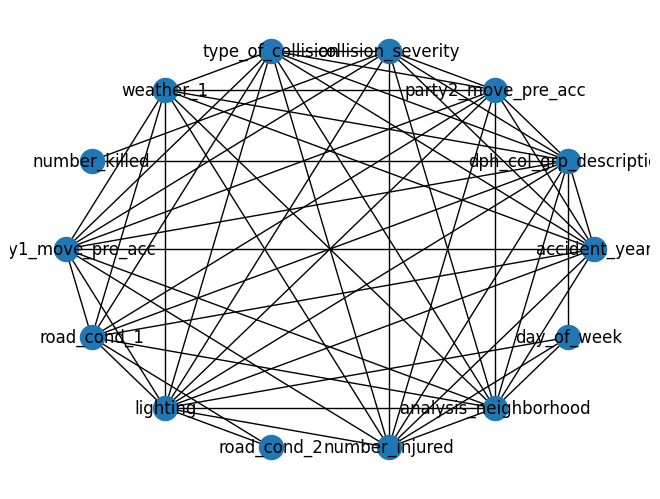

In [26]:
G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)
plt.show()

Now we just discovered a candidate skeleton! But that's not everything, with the skeleton object we can now check for conditional independencies of size 2 and 3.

We can use the `mat` parameter to pass the skeleton we just discovered, and the `set_sizes` parameter to check for conditional independencies of a particular size.

Before we do that, also let's take a look at the sepset object. Sepset refers to the separation set - it tells us which variables were used to "separate" two variables: i.e., ice cream sales and shark attacks are likely dependent, but if we control for the temperature, they become independent - (temperature) is the separation set.


In [28]:
sepsets[
    "number_killed", "day_of_week"
]  # likely to be the empty set - i.e., there's no association at all

[]

In [32]:
sepsets[
    "accident_year", "number_killed"
]  # likely to be the collision severity - i.e., if we control for the collision severity, then accident year and number killed are independent. probably the structure is accident_year -> collision_severity -> number_killed

['collision_severity']

In [ ]:
skeleton, sepsets = parallel_pc_skeleton(
    oracle, df.columns, mat=skeleton, set_sizes=[2, 3], n_jobs=20, verbose=True
)

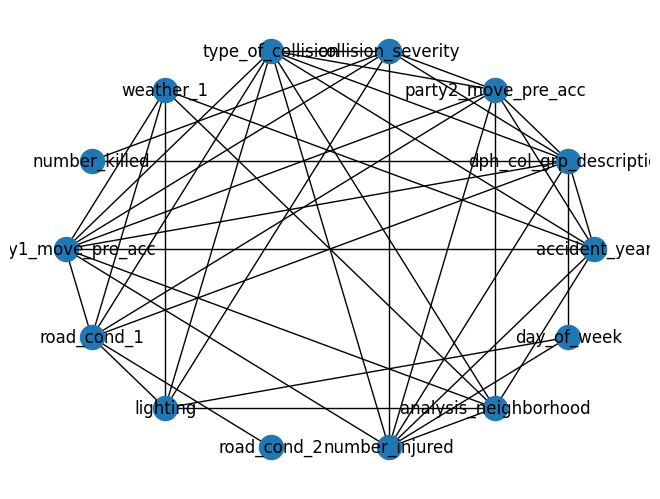

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_adjacency(skeleton)
nx.draw_circular(G, with_labels=True)
plt.show()

In [14]:
skeleton.loc[:, "number_killed"].sort_values(ascending=False)

dph_col_grp_description    1.0
collision_severity         1.0
accident_year              0.0
party2_move_pre_acc        0.0
type_of_collision          0.0
weather_1                  0.0
number_killed              0.0
party1_move_pre_acc        0.0
road_cond_1                0.0
lighting                   0.0
road_cond_2                0.0
number_injured             0.0
analysis_neighborhood      0.0
day_of_week                0.0
Name: number_killed, dtype: float64

In [15]:
skeleton.loc[:, "number_injured"].sort_values(ascending=False)

accident_year              1.0
dph_col_grp_description    1.0
party2_move_pre_acc        1.0
collision_severity         1.0
type_of_collision          1.0
party1_move_pre_acc        1.0
analysis_neighborhood      1.0
day_of_week                1.0
weather_1                  0.0
number_killed              0.0
lighting                   0.0
road_cond_1                0.0
number_injured             0.0
road_cond_2                0.0
Name: number_injured, dtype: float64

In [16]:
skeleton.loc[:, "collision_severity"].sort_values(ascending=False)

dph_col_grp_description    1.0
party2_move_pre_acc        1.0
type_of_collision          1.0
lighting                   1.0
party1_move_pre_acc        1.0
number_killed              1.0
number_injured             1.0
weather_1                  0.0
accident_year              0.0
collision_severity         0.0
road_cond_1                0.0
road_cond_2                0.0
analysis_neighborhood      0.0
day_of_week                0.0
Name: collision_severity, dtype: float64